# Fully connected neural network

We'll generate examples in the same way as the logistic regression example, just with more features.  This time, we'll use a fully connected neural network as our function approximator.


In [1]:
import numpy as np


def create_one_batch(batch_size: int, noise_std_dev: float):
    inputs = np.random.rand(batch_size, 20)
    noise = np.random.normal(0, noise_std_dev, batch_size)
    signals = np.sum(inputs, axis=1) + noise
    targets = (signals > 10) * np.ones(batch_size)
    return inputs, targets
    
    
def generate_example_batches(batch_size: int, n_batches: int, noise_std_dev):
    for _ in range(n_batches):
        next_batch = create_one_batch(batch_size, noise_std_dev)
        yield next_batch
    

## Building the model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class LogisticRegressor(nn.Module):
    
    def __init__(self):
        super(LogisticRegressor, self).__init__()
        self.first_hidden = nn.Linear(20, 20, bias=True)
        self.second_hidden = nn.Linear(20, 1, bias=True)
    
    def forward(self, X):
        X = torch.Tensor(X)
        activation_1 = self.first_hidden(X)
        transformed_1 = F.relu(activation_1)
        activation_2 = self.second_hidden(transformed_1)
        return torch.squeeze(activation_2)
    

def get_model_accuracy(model: nn.Module, X_test: np.array, y_test: np.array):
    scores = torch.sigmoid(model(X_test))
    y_pred = torch.round(scores)
    values_matched = torch.eq(torch.Tensor(y_test), y_pred)
    return torch.mean(values_matched.double())


def train_one_epoch(model: nn.Module, batches, lr: float):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_function = nn.BCEWithLogitsLoss()
    for X, y in batches:
        y_pred = model(X)
        loss = loss_function(y_pred, torch.Tensor(y))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return model

        
def train_one_model(lr: float, n_epochs: int, noise_std_dev: float):
    model = LogisticRegressor()
    X_test, y_test = next(generate_example_batches(batch_size=50, n_batches=1, noise_std_dev=noise_std_dev))
    initial_accuracy = get_model_accuracy(model, X_test, y_test)
    print("Accuracy before training (should be random): {0}".format(initial_accuracy))
    accuracies = [initial_accuracy]
    for epoch in range(n_epochs):
#         print("Beginning training epoch {0}".format(epoch))
        training_batches = generate_example_batches(batch_size=5, n_batches=50, noise_std_dev=noise_std_dev)
        model = train_one_epoch(model, training_batches, lr=lr)
        accuracy = get_model_accuracy(model=model, X_test=X_test, y_test=y_test)
#         print("Accuracy after training epoch {0}: {1}".format(epoch, accuracy))
        accuracies.append(accuracy)
    print("Final accuracy: {0}".format(accuracies[-1]))
    return accuracies    

Accuracy before training (should be random): 0.54
Final accuracy: 1.0
Accuracy before training (should be random): 0.4
Final accuracy: 0.9
Accuracy before training (should be random): 0.46
Final accuracy: 0.72


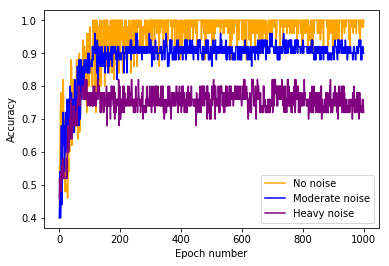

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt 

no_noise_accuracies = train_one_model(lr=0.01, n_epochs=1000, noise_std_dev=0.0)
noisy_accuracies = train_one_model(lr=0.01, n_epochs=1000, noise_std_dev=0.3)
heavy_noise_accuracies = train_one_model(lr=0.01, n_epochs=1000, noise_std_dev=1.0)

plt.figure()
plt.plot(no_noise_accuracies, color='orange', label="No noise")
plt.plot(noisy_accuracies, color='blue', label="Moderate noise")
plt.plot(heavy_noise_accuracies, color='purple', label="Heavy noise")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()
